# Classification: iris dataset

Methods covered in this notebook:
* Logistic regression
* Support Vector Machines (SVMs)
* Cross-validation (including GridSearchCV)
* Principal Components Analysis (PCA)
* Pipelines
* Validation curves
* Learning curves

In [2]:
# import packages

import numpy as np, pandas as pd, seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn')

In [3]:
# import some data

from sklearn.datasets import load_digits, load_iris
digits = load_digits()
iris = load_iris()


In [4]:
# logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

clf_LogReg = LogisticRegression(penalty='l2')
cv_scores = cross_val_score(clf_LogReg, iris.data, iris.target, cv=10)
print('Logistic Regression: Mean CV accuracy = ', np.mean(cv_scores)*100, '%')



Logistic Regression: Mean CV accuracy =  95.33333333333334 %


In [5]:
# SVM

from sklearn.svm import SVC

clf_svc = SVC()
cv_scores = cross_val_score(clf_svc, iris.data, iris.target, cv=10)
print('SVM: Mean CV accuracy = ' , np.mean(cv_scores)*100, '%')


SVM: Mean CV accuracy =  98.00000000000001 %


(150, 4)
(150, 2)
(150, 4)


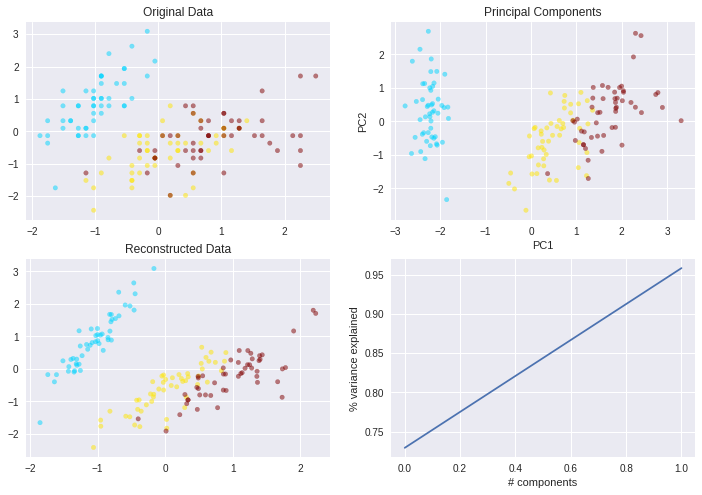

In [26]:
# PCA

from sklearn.decomposition import PCA
X, y = iris.data, iris.target

# normalize data
X = np.divide(X - np.mean(X,0), np.std(X,0))

pca = PCA(n_components=2) # n_components = 0.95, n_components = 3
pca.fit(X)
data_reduced = pca.transform(X)
data_reconstructed = pca.inverse_transform(data_reduced)

print(iris.data.shape)
print(data_reduced.shape)
print(data_reconstructed.shape)

fig = plt.figure(figsize=(12,8))
fig.add_subplot(2,2,1)
plt.scatter(X[:,0], X[:,1], 20, c=y, cmap='jet', alpha=.5, vmin=-1)
plt.title('Original Data')
fig.add_subplot(2,2,2)
plt.title('Principal Components'); plt.xlabel('PC1'); plt.ylabel('PC2')
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], 20, c=y, cmap='jet', alpha=0.5, vmin=-1);
fig.add_subplot(2,2,3)
plt.scatter(data_reconstructed[:,0], data_reconstructed[:,1], 20, c=y, cmap='jet', alpha=0.5, vmin=-1)
plt.title('Reconstructed Data')
#plt.legend(['Original', 'Reduced'])

fig.add_subplot(2,2,4)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# components')
plt.ylabel('% variance explained');

In [27]:
# pipeline

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(PCA(n_components=2),
                        SVC(kernel='linear', C=1.0))

param_grid = dict(pca__n_components=[1,2,3],
                  svc__C=np.logspace(-4, 1, 6),
                  svc__kernel=['rbf','linear'])

grid = GridSearchCV(pipe, param_grid=param_grid, scoring=['accuracy'], refit ='accuracy',
                    cv=10, n_jobs=1, verbose=0)

grid.fit(X, y)

print('Best score: ', grid.best_score_, '\n')
print('Best parameters: ', grid.best_params_, '\n')
print('Best estimator: ', grid.best_estimator_)

Best score:  0.9666666666666667 

Best parameters:  {'pca__n_components': 3, 'svc__C': 0.1, 'svc__kernel': 'linear'} 

Best estimator:  Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('svc', SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])


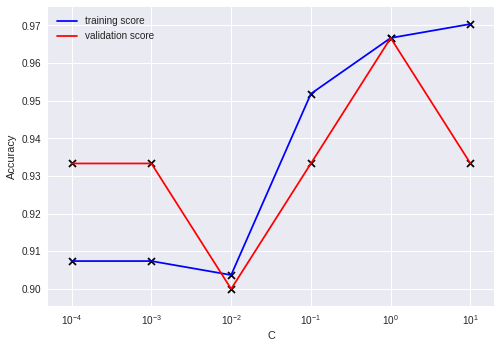

In [28]:
# validation curve

from sklearn.model_selection import validation_curve

# plot validation curve
cvals = svc__C=np.logspace(-4, 1, 6)
train_score, val_score = validation_curve(pipe, iris.data, iris.target,
                                          'svc__C',cvals, cv=10)

plt.plot(cvals, np.median(train_score, 1), color='blue', label='training score')
plt.plot(cvals, np.median(val_score, 1), color='red', label='validation score')
#plt.ylim(0,1)
plt.xscale('log')
plt.legend(loc='best')
plt.scatter(cvals, np.median(train_score, 1), marker = 'x',color='black')
plt.scatter(cvals, np.median(val_score, 1), marker = 'x', color='black')
plt.xlabel('C')
plt.ylabel('Accuracy');

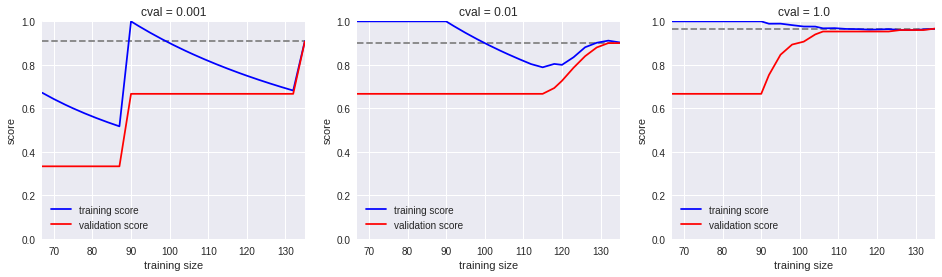

In [29]:
# learning curves

from sklearn.model_selection import learning_curve

def pipe(cval):
    return make_pipeline(PCA(n_components=2),
                        SVC(kernel='linear', C=cval))

cvals = [0.001, 0.01, 1.0]
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

for i, cval in enumerate(cvals):
    N, train_lc, val_lc = learning_curve(pipe(cval),
                                         iris.data, iris.target, cv=10,
                                         train_sizes=np.linspace(0.5, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
                 color='gray', linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('cval = {0}'.format(cval))
    ax[i].legend(loc='best')